# News Title Classification Project - Modeling (Transformer Model)

We know our LSTM / GRU perform well for this classification task, but how about Transformer model? Can Transformer beat LSTM / GRU best performance?

# Experiment with Transformer model results:

|**Model**|**Bidirectional**|**Optimizer**|**Best Epoch**|**Val loss**|**Val Precision**|**Val Recall**|**F1 score (macro)**|**NOTES**|
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|BERT base english uncased| Yes| Adam (1e-5)| 4| 0.1848| 0.9460| 0.9392| 0.94| Baseline|
|ALBERT base-v2 english uncased| Yes| Adam (1e-5)| 4| 0.2474| 0.9287| 0.9182| 0.92| I trained more than 10x, still didn't work for this dataset|
|DistilBERT english uncased| Yes| Adam (1e-5)| 4| 0.2014| 0.9392| 0.9290| 0.93| Less parameter than BERT|
|DistilBERT english uncased + text augmentation| Yes| Adam (1e-5)| 4| 0.1702| 0.9471| 0.9405| 0.93| Got better performance|
|BERT base + text augmentation + label smoothing| Yes| Adam (1e-5)| 4| 0.4604 (label smoothing)| 0.9539| 0.9413| 0.94| More better performance|

    I believe we still can improve Transformer model performance with bigger data (web crawling, more text augmentation etc), different optimizer like AdamW or RectifyAdam, Learning rate scheduler and another fancy technique. We can find on paper or kaggle competition notebook

### Experience:

    I've read, train Transformer model depends on their initialization, that's mean if we got BAD RESULT, we'll get BAD RESULT (better reset then retrain)

* For BERT i was lucky got 0.2502 val loss in first epoch, then got better in 4 epoch
* For ALBERT, sometimes i got 0.400 even 0.500 in first epoch, indeed it got bad result, later i got 0.300 in first epoch then got better result in the end of training
* DistilBERT and BERT have a more stable performance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K
import warnings

warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [14, 8]

pd.set_option('display.max_colwidth', None)

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [3]:
news_df_cleaned = pd.read_csv('/kaggle/input/gtect-project/news_title_cleaned.csv')

print('News df cleaned shape:', news_df_cleaned.shape)

News df cleaned shape: (64654, 3)


In [4]:
# convert label to label-encoder
cat2id = {
    'Technology': 0,
    'Business': 1,
    'Entertainment': 2,
    'Medical': 3
}

# convert back label-encoder to original label (after prediction)
id2cat = {
    0: 'Technology',
    1: 'Business',
    2: 'Entertainment',
    3: 'Medical'
}

In [5]:
news_df_cleaned['Category'] = news_df_cleaned['Category'].map(cat2id)

In [6]:
from sklearn.model_selection import train_test_split

# train_dataset 90% - test_dataset 10%
X_train, X_test, y_train, y_test = train_test_split(news_df_cleaned['News Title'],
                                                   news_df_cleaned['Category'],
                                                   test_size=0.1,
                                                   stratify=news_df_cleaned['Category'],
                                                   random_state=2020)

In [7]:
!pip install nlpaug -q

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [8]:
%%time

review_augmented = []

# aug = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2') # Text Generation
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.5) # higher aug_p = substitute more words

for news_title in tqdm(X_train):
    augmented_text = aug.augment(news_title)
    review_augmented.append(augmented_text)


CPU times: user 1min 13s, sys: 1.91 s, total: 1min 15s
Wall time: 1min 16s


In [9]:
train_aug = pd.DataFrame({'News Title': review_augmented,
                          'Category': y_train})

original_train = pd.DataFrame({'News Title': X_train,
                               'Category': y_train})

new_train = pd.concat([train_aug, original_train])

print('Original shape:', original_train.shape)
print('Augmented shape:', train_aug.shape)
print('new train (combined) shape:', new_train.shape)

Original shape: (58188, 2)
Augmented shape: (58188, 2)
new train (combined) shape: (116376, 2)


In [10]:
#  train_dataset 90% - validation_dataset 10%
X_train, X_valid, y_train, y_valid = train_test_split(new_train['News Title'],
                                                      new_train['Category'],
                                                      test_size=0.1,
                                                      stratify=new_train['Category'],
                                                      random_state=2020)

print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (104738,)
X_valid shape: (11638,)
X_test shape: (6466,)


In [11]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

## Create Transformer model

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

In [13]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen)
    
    return np.array(enc_di['input_ids'])

In [14]:
from tensorflow.keras.losses import CategoricalCrossentropy

# use label smoothing (soft-labeling instead of hard-labeling)

In [15]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token) # 4 class label to classify
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=[tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    
    return model

## Use TPU for training (faster)

Transformers model takes a long time to train, especially in huge dataset, since Kaggle provides 30 hours free TPU / week for free, i prefer use TPU for saving my time (only took 2 minutes to complete train)

    TPUs are hardware accelerators specialized in deep learning tasks.

In [16]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [17]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# BERT-English; uncased: not use uppercase (only lowercase)
MODEL = 'bert-base-uncased'
# MODEL = 'albert-base-v2'
# MODEL = 'distilbert-base-uncased'

In [18]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [19]:
MAXLEN = max(map(len, news_df_cleaned['News Title'].str.split()))
print('max_len:', MAXLEN)

max_len: 22


In [20]:
%%time 

x_train = regular_encode(X_train.values, tokenizer, maxlen=MAXLEN)
x_valid = regular_encode(X_valid.values, tokenizer, maxlen=MAXLEN)
x_test = regular_encode(X_test.values, tokenizer, maxlen=MAXLEN)

CPU times: user 57.7 s, sys: 105 ms, total: 57.8 s
Wall time: 57.8 s


In [21]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [22]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAXLEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 22)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 22, 768), (None,  109482240 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3076      
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________
CPU times: user 25.3 s, sys: 6.51 s, total: 31.8 s
Wall time: 55.4 s


In [23]:
n_steps = X_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
)

Epoch 1/4
818/818 [==============================] - 65s 79ms/step - precision: 0.9052 - recall: 0.8253 - loss: 0.6122 - val_precision: 0.9327 - val_recall: 0.9005 - val_loss: 0.5166
Epoch 2/4
818/818 [==============================] - 53s 65ms/step - precision: 0.9409 - recall: 0.9100 - loss: 0.4999 - val_precision: 0.9445 - val_recall: 0.9217 - val_loss: 0.4848
Epoch 3/4
818/818 [==============================] - 53s 65ms/step - precision: 0.9576 - recall: 0.9381 - loss: 0.4556 - val_precision: 0.9499 - val_recall: 0.9327 - val_loss: 0.4709
Epoch 4/4
818/818 [==============================] - 54s 66ms/step - precision: 0.9695 - recall: 0.9570 - loss: 0.4267 - val_precision: 0.9539 - val_recall: 0.9413 - val_loss: 0.4604


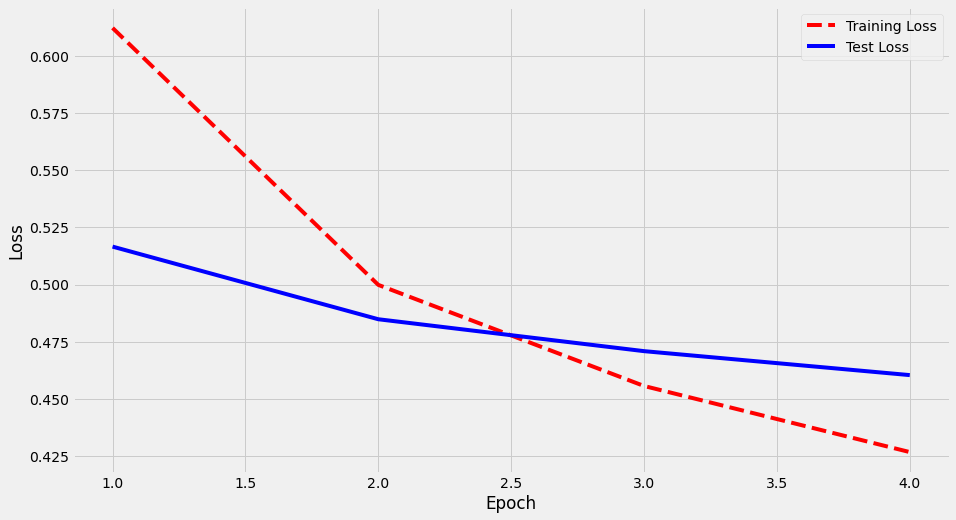

In [24]:
# Get training and test loss histories
training_loss = train_history.history['loss']
test_loss = train_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1658
           1       0.90      0.94      0.92      1745
           2       0.98      0.96      0.97      2363
           3       0.93      0.94      0.94       700

    accuracy                           0.94      6466
   macro avg       0.93      0.94      0.94      6466
weighted avg       0.94      0.94      0.94      6466



In [27]:
id2cat = {
    0: 'Technology',
    1: 'Business',
    2: 'Entertainment',
    3: 'Medical'
}

y_pred_decoded = pd.Series(y_pred).map(id2cat)

In [33]:
pd.DataFrame({'News Title': X_test.reset_index(drop=True),
              'Category': y_pred_decoded}).sample(10)

,News Title,Category
3542,gold prices to remain lower today emkay,Business
5994,dollar rises in asia,Business
4239,chicago again gets an f from lung association for poor air quality,Technology
5998,google inc goog continues on self driving odyssey,Technology
4838,the associated pressmay updated minutes ago,Entertainment
5413,first asteroid with rings discovered,Technology
519,tesla stock rises on jersey vote wedbush rates it outperform,Business
1004,improving macbook battery life in,Technology
3243,dropbox announces carousel an app to organize backup your photos to,Technology
5472,boeing s capsule to act as a space shuttle,Technology


In [29]:
import h5py

model.save_weights("bert_bestmodel.h5")
print("Saved model weights")

Saved model weights
